In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [30]:
df = pd.read_csv("C:/Users/sudha/OneDrive/Desktop/kaggle/PJME_hourly.csv")
df.head()



,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [31]:
df.columns = ["datetime", "energy_mw"]
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()

,datetime,energy_mw
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [32]:
df = df.sort_values("datetime")
df = df.set_index("datetime")
df.head()

,energy_mw
datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [33]:
df.index.inferred_freq


In [34]:
df.index.duplicated().sum()


np.int64(4)

In [35]:
df = df.groupby(df.index).mean()


In [36]:
df = df.asfreq("h")

In [37]:
df.isnull().sum()

energy_mw    30
dtype: int64

In [38]:
df["energy_mw"] = df["energy_mw"].interpolate(method="time")

In [39]:
df["energy_mw"] = df["energy_mw"].interpolate(method="time")


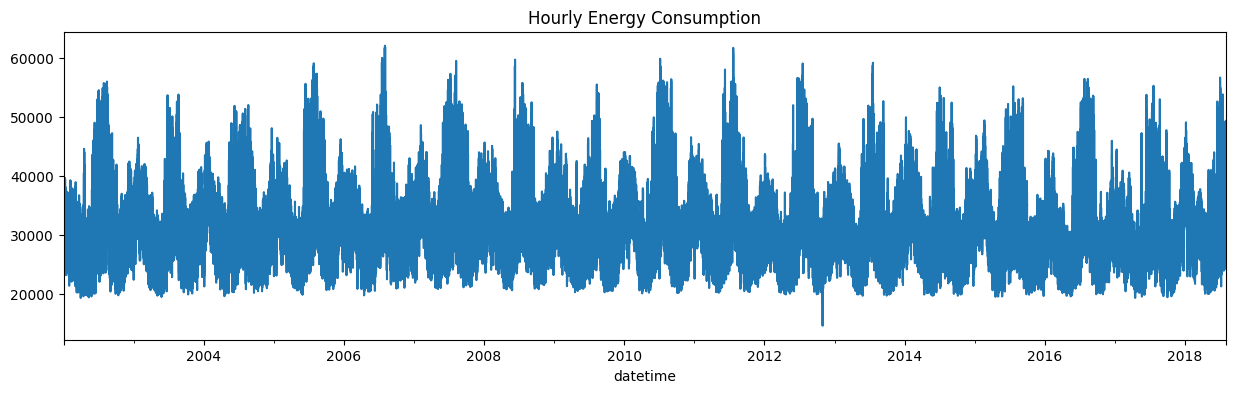

In [40]:
df["energy_mw"].plot(figsize=(15,4), title="Hourly Energy Consumption")
plt.show()


In [41]:
q1 = df["energy_mw"].quantile(0.25)
q3 = df["energy_mw"].quantile(0.75)
iqr = q3 - q1

outliers = df[
    (df["energy_mw"] < q1 - 1.5 * iqr) |
    (df["energy_mw"] > q3 + 1.5 * iqr)
]

len(outliers)


3460

In [42]:
train = df.loc[: "2018-12-31"]
test  = df.loc["2019-01-01":]

print(train.shape, test.shape)


(145392, 1) (0, 1)


In [43]:
train.to_csv("train_clean.csv")
test.to_csv("test_clean.csv")


Training Shape: (113951, 6)
Testing Shape: (31441, 6)
Best Params: {'n_estimators': 300, 'min_samples_leaf': 5, 'max_depth': 10}


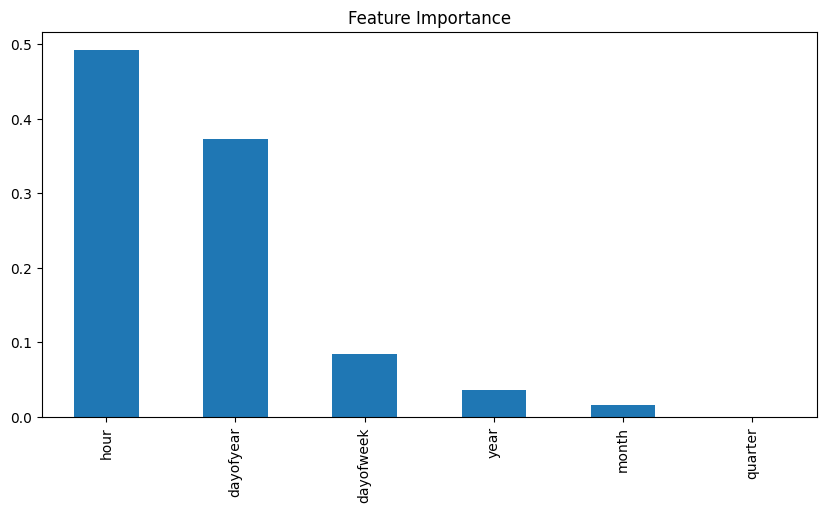

Final MAE: 2950.772004359339
Final RMSE: 3864.4398573072353
Model saved to energy_forecast_model.pkl
Predicted Energy: 32506.938823536188


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Feature Engineering ---
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df_feat = create_features(df)

# --- 2. Data Splitting ---
# Using 2015 as split date to ensure test set is not empty (data ends in 2018)
split_date = '2015-01-01'

train_feat = df_feat.loc[df_feat.index < split_date]
test_feat = df_feat.loc[df_feat.index >= split_date]

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'energy_mw'

X_train = train_feat[FEATURES]
y_train = train_feat[TARGET]

X_test = test_feat[FEATURES]
y_test = test_feat[TARGET]

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

# --- 3. Model Training & Tuning ---
rf = RandomForestRegressor()

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 15, 20],
    "min_samples_leaf": [1, 3, 5],
}

search = RandomizedSearchCV(
    rf,
    param_grid,
    n_iter=5,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=1,
    random_state=42
)

# Fit on training data
search.fit(X_train, y_train)

best_model = search.best_estimator_
print(f"Best Params: {search.best_params_}")

# --- 4. Feature Importance ---
importance = pd.Series(
    best_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(10,5))
importance.head(15).plot(kind="bar", title="Feature Importance")
plt.show()

# --- 5. Evaluation & Saving ---
y_pred_final = best_model.predict(X_test)

mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("Final MAE:", mae_final)
print("Final RMSE:", rmse_final)

# Save the model
joblib.dump(best_model, "energy_forecast_model.pkl")
print("Model saved to energy_forecast_model.pkl")

# Make a sample prediction
sample = X_test.iloc[[0]]
prediction = best_model.predict(sample)

print("Predicted Energy:", prediction[0])

In [51]:
print(sample)



            hour  dayofweek  quarter  month  year  dayofyear
datetime                                                    
2015-01-01     0          3        1      1  2015          1


In [52]:
print(X_test)

                     hour  dayofweek  quarter  month  year  dayofyear
datetime                                                             
2015-01-01 00:00:00     0          3        1      1  2015          1
2015-01-01 01:00:00     1          3        1      1  2015          1
2015-01-01 02:00:00     2          3        1      1  2015          1
2015-01-01 03:00:00     3          3        1      1  2015          1
2015-01-01 04:00:00     4          3        1      1  2015          1
...                   ...        ...      ...    ...   ...        ...
2018-08-02 20:00:00    20          3        3      8  2018        214
2018-08-02 21:00:00    21          3        3      8  2018        214
2018-08-02 22:00:00    22          3        3      8  2018        214
2018-08-02 23:00:00    23          3        3      8  2018        214
2018-08-03 00:00:00     0          4        3      8  2018        215

[31441 rows x 6 columns]


In [53]:
print(X_train)

                     hour  dayofweek  quarter  month  year  dayofyear
datetime                                                             
2002-01-01 01:00:00     1          1        1      1  2002          1
2002-01-01 02:00:00     2          1        1      1  2002          1
2002-01-01 03:00:00     3          1        1      1  2002          1
2002-01-01 04:00:00     4          1        1      1  2002          1
2002-01-01 05:00:00     5          1        1      1  2002          1
...                   ...        ...      ...    ...   ...        ...
2014-12-31 19:00:00    19          2        4     12  2014        365
2014-12-31 20:00:00    20          2        4     12  2014        365
2014-12-31 21:00:00    21          2        4     12  2014        365
2014-12-31 22:00:00    22          2        4     12  2014        365
2014-12-31 23:00:00    23          2        4     12  2014        365

[113951 rows x 6 columns]
